<center>

<table>
<tr><td>
<img src='./img/optimize.jpg' width='200'>
</td><td>
<img src='./img/sber.jpg' width='400'>
</td><td>
<img src='./img/optimize.jpg' width='200'>
</td></tr>
</table>

</center>


**Авторы материала:** Денис Димитров, Алексей Рябых. Материал можно использовать в любых целях (редактировать, поправлять и брать за основу), но с обязательным упоминанием авторов материала.

# <center>Часть 4. Оптимизация инкассаторских поездок</center>

# План:

1. О задаче оптимизации
    - Методы оптимизации
    - Методы оптимизации (когда множество состояний дискретно): алгоритм имитации отжига, генетический алгоритм
    - Применим к нашей задаче
2. Элементы внутридневной логики + риск-параметры: что можно делать

## 1. О задаче оптимизации

In [1]:
import numpy as np
#np.random.seed(10)

In [2]:
import numpy as np
import pandas as pd
import datetime
import sys
import random
import math
from copy import deepcopy
import OptimizationPack
from OptimizationPack import CashCenter, Optimizer
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 2400)
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# если нужно перезагрузить модуль оптимизации после правок, не роняя ядро
import imp
imp.reload(OptimizationPack)
from OptimizationPack import CashCenter, Optimizer

In [5]:
# from IPython.display  import HTML

# HTML('''<script>
# code_show=true;
# function code_toggle() {
#     if (code_show){
#     $('div.input').hide();
#     } else {
#     $ ('div.input').show();
#     }
#     code_show = !code_show
#     }
#     $( document ).ready(code_toggle);
#     </script>
#     <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Рассмотрим Тверской КИЦ

In [6]:
name_cash_center = 'Тверской'

In [7]:
atm_data = OptimizationPack.atm_data
atm_costs = OptimizationPack.costs

In [8]:
file = open('./data/lecture4/' + name_cash_center + '/0_' + name_cash_center + '.csv')
atm_ids_table = pd.read_csv(file)
file.close()

In [9]:
L_ATM = sorted(set(atm_data.ATM_ID.unique()).intersection(set(atm_ids_table.ATM_ID.unique())))
num_atms = len(L_ATM)
atm_capacity = np.array([30e6 for _ in range(num_atms)])

In [10]:
atm_data=atm_data[atm_data.ATM_ID.isin(L_ATM)]

In [11]:
atm_data.head()

,ATM_ID,CLIENT_IN,CLIENT_IN_BEFORE_LOAD,CLIENT_OUT,CLIENT_OUT_BEFORE_LOAD,CURR,LOAD_IN,LOAD_OUT,INITIAL_BALANCE
2015-01-01,786314,0.0,0.0,274800,0.0,643.0,0.0,0.0,11700600
2015-01-01,784073,0.0,0.0,0,0.0,643.0,0.0,0.0,1426000
2015-01-01,780262,0.0,0.0,0,0.0,643.0,0.0,0.0,11987400
2015-01-01,780816,0.0,0.0,0,0.0,643.0,0.0,0.0,8607000
2015-01-01,830093,0.0,0.0,3500,0.0,643.0,0.0,0.0,9024600


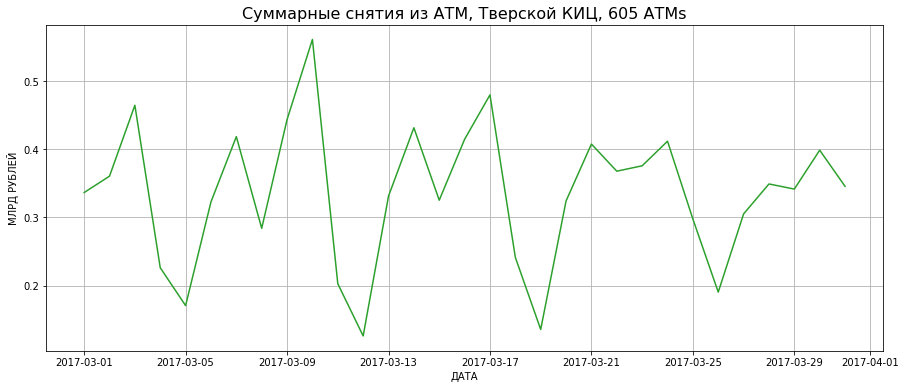

In [12]:
plt.figure(figsize=(15,6))
plt.title('Суммарные снятия из ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(atm_data.groupby(by=atm_data.index)['LOAD_OUT'].sum()['2017-03-01':'2017-03-31'] / 1e9, color='tab:green')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.grid(True)

Построим интересные картинки по зонам

In [13]:
import gmaps
import pandas as pd

gmaps.configure(api_key="")

In [14]:
data_kits = atm_costs[atm_costs.ATM_ID.isin(L_ATM)]

In [15]:
data1 = data_kits[data_kits.NEW_ZONE == 1][['LATITUDE', 'LONGITUDE']]
data2 = data_kits[data_kits.NEW_ZONE == 2][['LATITUDE', 'LONGITUDE']]
data3 = data_kits[data_kits.NEW_ZONE == 3][['LATITUDE', 'LONGITUDE']]
data4 = data_kits[data_kits.NEW_ZONE == 4][['LATITUDE', 'LONGITUDE']]
data5 = data_kits[data_kits.NEW_ZONE == 5][['LATITUDE', 'LONGITUDE']]

data1_layer = gmaps.symbol_layer(
    data1, fill_color="blue",
    stroke_color="blue", scale=2
)

data2_layer = gmaps.symbol_layer(
    data2, fill_color="green",
    stroke_color="green", scale=2,
)

data3_layer = gmaps.symbol_layer(
    data3, fill_color="red",
    stroke_color="red", scale=2
)

data4_layer = gmaps.symbol_layer(
    data4, fill_color="black",
    stroke_color="black", scale=3
)

data5_layer = gmaps.symbol_layer(
    data5, fill_color="purple",
    stroke_color="purple", scale=4
)

In [16]:
fig = gmaps.figure()
fig.add_layer(data1_layer)
fig.add_layer(data2_layer)
fig.add_layer(data3_layer)
fig.add_layer(data4_layer)
fig.add_layer(data5_layer)

In [17]:
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [18]:
! jupyter nbextension enable --py --sys-prefix gmaps

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py:19: VisibleDeprecationWarning: zmq.eventloop.minitornado is deprecated in pyzmq 14.0 and will be removed.
    Install tornado itself to use zmq with the tornado IOLoop.
    
  from jupyter_client.session import utcnow as now
Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK


In [19]:
fig

Figure(layout=FigureLayout(height='420px'))

## <center><span style = "color: blue">Зона 1</span>  --- <span style = "color: green">Зона 2</span> --- <span style = "color: red">Зона 3</span> --- <span style = "color: black">Зона 4</span> --- <span style = "color: purple">Зона 5</span>

### Прогнозы 14-дневные! Это параметр size_window по умолчанию везде далее

In [ ]:
global_period = ['2017-03-01', '2017-03-31']
size_window = 14
power = np.array([200 for _ in range(size_window)]) # берем по среднему количеству инкассаций
# OptiCash
priority = {'atm': 1.0}
f_rate = 0.055

In [ ]:
n_days = (pd.to_datetime(global_period[1]) - pd.to_datetime(global_period[0])).days + 1

In [ ]:
predictions_patriot = []

for num_pr in range(31):
    file_name = './data/lecture4/' + name_cash_center + '/' + str(num_pr) + '_' + name_cash_center + '.csv'
    file = open(file_name)
    forecast_frame = pd.read_csv(file)
    file.close()
    forecast_frame = forecast_frame.rename(columns={forecast_frame.columns[0]: 'DATE'})
    forecast_frame.sort_values(['DATE', 'ATM_ID'], inplace=True)
    dr = forecast_frame.DATE.unique()
    forecast_table = np.zeros(shape=(num_atms,size_window))
    for i_day, day in enumerate(dr):
        forecast_table[:,i_day] = forecast_frame[forecast_frame.DATE == day]['prediction']
    predictions_patriot.append(forecast_table)
    print(file_name)

### Итак, запустим алгоритм оптимизации на тех прогнозах, которые считали выше

In [ ]:
fat = 1.2
global_period_extended = pd.date_range(start=global_period[0], end=global_period[1], 
                                       freq = 'D')
num_days = len(global_period_extended)

In [ ]:
optimum = []
patriot_raw_downtimes_list = []
patriot_encash_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
patriot_load_in_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
patriot_encash_hours_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
patriot_losts_table = np.zeros(shape=(num_atms, num_days), dtype='int64')

tmp = np.zeros(num_atms)
for index, ID in enumerate(L_ATM):
    tmp[index] = atm_data[atm_data['ATM_ID'] == ID][global_period[0]:global_period[1]]['INITIAL_BALANCE'].iloc[0]
atm_initial_balances = (np.floor(tmp / 10) * 10).astype('int64')

update_initial_balance = [atm_initial_balances]


for i_day, d1 in enumerate(global_period_extended):
    print([str(d1), str(d1 + datetime.timedelta(size_window-1))])
    
    KITS_slice = CashCenter(atm_ids=L_ATM, 
                            times=[str(d1), str(d1 + datetime.timedelta(size_window-1))], 
                            power=power, 
                            priority=priority, 
                            atm_capacity=atm_capacity, 
                            f_rate=f_rate)
    KITS_slice.set_data()   # криво, потому что приходится две строчки ниже писать
    KITS_slice._atm_initial_balances = update_initial_balance[-1]
    KITS_slice._atm_predictions = (np.ceil(fat * predictions_patriot[i_day] / 10) * 10).astype('int64')
    KITS_slice.set_full_masks()
    KITS_slice.set_state()
    
    opt = Optimizer(KITS_slice)
    optimum.append(opt.optimize(max_iter=5000, num_jump=3))

    patriot_encash_table[:, i_day] = optimum[-1][0][:, 0]
    uploads_hours = KITS_slice.table_upload(optimum[-1][0], timestamp='intraday')
    patriot_load_in_table[:, i_day] = uploads_hours[0][:, 0]
    patriot_encash_hours_table[:, i_day] = uploads_hours[1]
    losts_downtimes = KITS_slice.table_lost(optimum[-1][0], kind='atm', 
                                            facts=True, timestamp ='intraday')
    patriot_losts_table[:, i_day] = losts_downtimes[0][:, 0]
    patriot_raw_downtimes_list.append(losts_downtimes[1])

    update_initial_balance.append(losts_downtimes[0][:, 0])

In [ ]:
patriot_load_out_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
    
for i_atm, ID in enumerate(L_ATM):
    patriot_load_out_table[i_atm, :] = patriot_load_in_table[i_atm, :] - np.array(atm_data[atm_data['ATM_ID'] == ID]['CLIENT_OUT']['2017-03-01':'2017-03-31']) + np.array(update_initial_balance)[:,i_atm][:-1] - patriot_losts_table[i_atm, :]

patriot_load_out_table = np.where(patriot_load_out_table < 0, 0, patriot_load_out_table)

patriot_funding_costs_table = patriot_losts_table * f_rate / 365
patriot_encash_costs_table = np.zeros(shape=(num_atms, num_days))

for i_atm, ID in enumerate(L_ATM):
    patriot_encash_costs_table[i_atm, :] = patriot_encash_table[i_atm, :] * (atm_costs[atm_costs['ATM_ID'] == ID]['NEW_EXPENSE'].iloc[0] + atm_costs[atm_costs['ATM_ID'] == ID]['NEW_KASSA'].iloc[0])
    
patriot_encash_hours_table = np.where(patriot_encash_hours_table == 24, None, patriot_encash_hours_table)

In [ ]:
patriot_downtimes_list = []
for ind in range(len(patriot_raw_downtimes_list)):
    downtimes = deepcopy(patriot_raw_downtimes_list[ind])
    if ind == 0:
        for j in range(len(downtimes)):
            patriot_downtimes_list.append([])
            for k in range(len(downtimes[j])):
                if isinstance(downtimes[j][k], list):
                    patriot_downtimes_list[j].append(downtimes[j][k])
    else:
        for j in range(len(downtimes)):
            for k in range(len(downtimes[j])):
                if isinstance(downtimes[j][k], list):
                    downtimes[j][k][0] = ind
                    patriot_downtimes_list[j].append(downtimes[j][k])

In [ ]:
patriot_counts = []
for j in range(len(patriot_downtimes_list)):
    patriot_counts.append(len(patriot_downtimes_list[j]))

### Посмотрим, как все считается сейчас

In [ ]:
opticash_load_in_table = np.zeros(shape=(num_atms, num_days), dtype='int64')

for i_atm, ID in enumerate(L_ATM):
    opticash_load_in_table[i_atm, :] = np.array(atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_IN'])

opticash_encash_table = np.where(opticash_load_in_table > 0, 1, 0)

opticash_losts_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
opticash_load_out_table = np.zeros(shape=(num_atms, num_days), dtype='int64')

for i_atm, ID in enumerate(L_ATM):
    opticash_losts_table[i_atm, :] = np.array(atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_IN'] - (atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['CLIENT_OUT']- (atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['INITIAL_BALANCE'] - atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_OUT'])))
    opticash_load_out_table[i_atm, :] = np.array(atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_OUT'])

opticash_funding_costs_table = opticash_losts_table * f_rate / 365

opticash_encash_costs_table = np.zeros(shape=(num_atms, num_days))

for i_atm, ID in enumerate(L_ATM):
    opticash_encash_costs_table[i_atm, :] = opticash_encash_table[i_atm, :] * (atm_costs[atm_costs['ATM_ID'] == ID]['NEW_EXPENSE'].iloc[0] + atm_costs[atm_costs['ATM_ID'] == ID]['NEW_KASSA'].iloc[0])

## Построим графики

In [ ]:
plt.figure(figsize=(15,24.3))
plt.subplots_adjust(hspace=0.3)

plt.subplot(4,1,1)
plt.title('Остатки в ATM на конец дня, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_losts_table, axis=0) / 1e9, label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_losts_table, axis=0) / 1e9, label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.legend()
plt.grid(True)

plt.subplot(4,1,2)
plt.title('Расход средств из КИЦа на загрузку ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_load_in_table, axis=0) / 1e9, label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_load_in_table, axis=0) / 1e9, label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.legend()
plt.grid(True)

plt.subplot(4,1,3)
plt.title('Количество инкассаций в день для обслуживания ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_encash_table, axis=0), label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_encash_table, axis=0), label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('КОЛИЧЕСТВО ИНКАССАЦИЙ')
plt.legend()
plt.grid(True)

plt.subplot(4,1,4)
plt.title('Суммарная выгрузка из ATM в момент загрузки, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_load_out_table, axis=0) / 1e9, label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_load_out_table, axis=0) / 1e9, label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
plt.figure(figsize=(17,18))

plt.subplot(2,1,1)
plt.title('Гистограмма простоев ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.hist(patriot_counts, bins=100, label='PATRIOT. Средний простой = ' + str(np.round(np.mean(patriot_counts), 1)) + ' часа', color='tab:blue')
plt.xlabel('ПРОСТОЙ В ЧАСАХ (ЗА МАРТ 2017 ГОДА)')
plt.ylabel('КОЛИЧЕСТВО ATM')
plt.legend()
plt.grid(True)

plt.show()

### Теперь посмотрим внимательнее, как изменились загрузки для каждого конкретного банкомата

In [ ]:
atm_predictions = np.zeros(shape=(num_atms, num_days))
for dd in range(num_days):
    atm_predictions[:,dd] = predictions_patriot[dd][:,0]

atm_facts = np.zeros(shape=(num_atms, num_days))
for index, ID in enumerate(L_ATM):
    atm_facts[index, :] = atm_data[atm_data['ATM_ID'] == ID][global_period[0]:global_period[1]]['CLIENT_OUT']

In [ ]:
index_gen = pd.date_range(start=pd.to_datetime('2017-03-01'), end=pd.to_datetime('2017-03-31'), freq='D')
for ID in random.sample(range(num_atms), 50):
    if np.max(atm_facts[ID, :]) < 5e6:
        start = deepcopy(pd.to_datetime(global_period[0]))
        end = deepcopy(pd.to_datetime(global_period[0])) + datetime.timedelta(size_window-1)
        tss = []

        for i in range(num_days):
            ts = pd.DataFrame(optimum[i][0][ID, :], index = pd.date_range(start=start, end=end))
            start = start + datetime.timedelta(1)
            end = end + datetime.timedelta(1)
            tss.append(ts)

        tmp = deepcopy(tss[0])
        for i in range(1, len(tss)):
            left, right = deepcopy(tmp.align(tss[i], fill_value = 0))
            tmp = left + right
        tmp = tmp[:'2017-03-31']
    
        plt.figure(figsize = (17,4))
        plt.suptitle('ID = ' + str(L_ATM[ID]), fontsize=20)
        plt.bar(tmp.index, tmp.values.reshape(1, -1)[0])
        pp = pd.Series(patriot_encash_table[ID, :], index = pd.date_range(start=pd.to_datetime('2017-03-01'), end=pd.to_datetime('2017-03-31')))
        ax = plt.axes()
        ymin, ymax = ax.get_ylim()
        ax.vlines(x=pp[pp == 1].index, ymin=ymin, ymax=ymax, color='r')
        ax.set_ylim(ymin, ymax)
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(17,4))
        AAA = np.sum(patriot_funding_costs_table[ID, :])
        BBB = np.sum(patriot_encash_costs_table[ID, :])
        
        plt.suptitle('Funding costs = ' + str(np.ceil(AAA).astype('int64')) + '                             ' +
                     ' Encashment costs = ' + str(np.ceil(BBB).astype('int64')) + '\n' + 
                     'SUM = ' + str(np.ceil(AAA + BBB).astype('int64'))) 
        plt.plot(pd.Series(patriot_losts_table[ID, :], index=index_gen))
        plt.plot(pd.Series(np.where(patriot_encash_table[ID, :] == 1, patriot_load_in_table[ID, :], np.nan), index=index_gen), 'ro')
        plt.vlines(x=index_gen, 
                   ymin=np.where(patriot_encash_table[ID, :] == 1, patriot_losts_table[ID, :], np.nan),
                   ymax = np.where(patriot_encash_table[ID, :] == 1, patriot_load_in_table[ID, :], np.nan), color = 'tab:orange', alpha = 0.7)
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(17,4))
        CCC = np.sum(opticash_funding_costs_table[ID, :])
        DDD = np.sum(opticash_encash_costs_table[ID, :])
        plt.suptitle('Funding costs = ' + str(np.ceil(CCC).astype('int64')) + '                             ' +
                     ' Encashment costs = ' + str(np.ceil(DDD).astype('int64')) + '\n' + 
                     'SUM = ' + str(np.ceil(CCC + DDD).astype('int64'))) 
        plt.plot(pd.Series(opticash_losts_table[ID, :], index=index_gen))
        plt.plot(pd.Series(np.where(opticash_encash_table[ID, :] == 1, opticash_load_in_table[ID, :], np.nan), index=index_gen), 'ro')
        plt.vlines(x=index_gen, 
                   ymin=np.where(opticash_encash_table[ID, :] == 1, opticash_losts_table[ID, :], np.nan),
                   ymax = np.where(opticash_encash_table[ID, :] == 1, opticash_load_in_table[ID, :], np.nan), color = 'tab:orange', alpha = 0.7)
        plt.grid(True)
        plt.show()
        

        plt.figure(figsize=(17,4))
        plt.grid(True)
        plt.plot(atm_predictions[ID, :], 'r', label='Predictions')
        plt.plot(atm_facts[ID,:], 'g', label='Facts')
        plt.legend()
        plt.show()
        print('\n\n\n\n')

In [ ]:
plt.figure(figsize=(17,4))
plt.xlabel('DAY OF THE MONTH')
plt.ylabel('CLIENTFLOW IN HOURS OF SERVICE')
plt.plot(atm_facts[201,:] / 20000, 'g', label='REAL CLIENTFLOW')
plt.plot(atm_predictions[201, :] / 20000, 'r', label='PREDICTED CLIENTFLOW')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(17,8))
plt.plot(optimum[0][2][0])
plt.grid(True)

In [ ]:
from copy import deepcopy

In [ ]:
df = deepcopy(optimum[1][1][0])
for j in range(1,2000):
    df += optimum[1][1][j]
df = df/2000

In [ ]:
optimum[1][1][0]

In [ ]:
import seaborn as sns

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,17))
sns.heatmap(optimum[1][1][0][:50, :], ax = axs[0], cmap='RdBu_r')
sns.heatmap(optimum[1][1][-1][:50,:], ax = axs[1], cmap='RdBu_r')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,17))
sns.heatmap(optimum[1][1][0][:50, :], ax = axs[0], cmap='RdBu_r')
sns.heatmap(df[:50,:], ax = axs[1], cmap='RdBu_r')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,17))
sns.heatmap(optimum[1][1][0][:50, :], ax = axs[0], cmap='RdBu_r')
sns.heatmap(optimum[1][1][-1][:50, :], ax = axs[1], cmap='RdBu_r')
plt.show()

# ВДД алгоритм

In [ ]:
atm_intraday = pd.read_csv('./data/lecture4/atm_intraday.csv', index_col=0, parse_dates=True)
atm_intraday = atm_intraday.rename(columns={'new_value': 'sum'})
atm_intraday['date_id'] = pd.to_datetime(atm_intraday['date_id'])
atm_intraday['dow'] = atm_intraday['date_id'].dt.weekday
atm_intraday = atm_intraday[atm_intraday.date_id != '2018-01-13']
atm_intraday.index = range(atm_intraday.shape[0])
atm_intraday['new_sum'] = np.where(atm_intraday['sum'] < 0, 0, atm_intraday['sum'])

In [ ]:
list_ids = L_ATM
n_ids = num_atms
dia = atm_intraday[atm_intraday.ATM_ID.isin(list_ids)]

dia = dia.sort_values(['ATM_ID', 'dow', 'hour'])

dia_each = dia.groupby(by=['ATM_ID', 'dow', 'hour'])['new_sum'].mean().reset_index()
dia_each.index = range(dia_each.shape[0])

for _id in list_ids:
    if _id not in dia_each.ATM_ID.unique():
        print('There is not intraday data for ID = ' + str(_id) + ', type = ' + 'atm' + '\n' +
              'The intraday distribution was set as mean for all ' + 'atm' + 's')

A1 = []
for i_id in range(n_ids):
    A2 = []
    for i_dow in range(7):
        d_app = np.array(dia_each[(dia_each.ATM_ID == list_ids[i_id]) & (dia_each.dow == i_dow)]['new_sum'])
        if len(d_app) == 24 and np.all(d_app != np.inf):
            A2.append(list(np.ceil(d_app)))
        else:
            A2.append([0] * 24)
    A1.append(A2)
A1 = np.array(A1)

for i_id in range(n_ids):
    for i_dow in range(7):
        sum_day = np.sum(A1[i_id, i_dow])
        if sum_day != 0:
            A1[i_id, i_dow] = A1[i_id, i_dow] / sum_day
        else:
            A1[i_id, i_dow] = np.array([0] * 24)

dia_all = dia.groupby(by=['dow', 'hour'])['new_sum'].mean().reset_index()
dia_all.index = range(dia_all.shape[0])
A2 = []
for i_dow in range(7):
    d_app = np.array(dia_all[dia_all.dow == i_dow]['new_sum'])
    if len(d_app) == 24 and np.all(d_app != np.inf):
        A2.append(list(np.ceil(d_app)))
    else:
        A2.append([0] * 9 + [1] * 12 + [0] * 3)
A2 = np.array(A2)

for i_dow in range(7):
    sum_day = np.sum(A2[i_dow])
    if sum_day != 0:
        A2[i_dow] = A2[i_dow] / sum_day
    else:
        A2[i_dow] = np.array([0.0] * 9 + [1/12] * 12 + [0.0] * 3)

for i in range(n_ids):
    for j in range(7):
        if np.sum(A1[i, j]) < 0.1:
            A1[i, j] = A2[j].copy()
        m1, arg_m1 = np.max(A1[i, j]), np.argmax(A1[i, j])
        A1[i, j, arg_m1] = 1000
        for k in range(24):
            if k != arg_m1:
                A1[i, j, k] = np.ceil(A1[i, j, k] * 1000)
                A1[i, j, arg_m1] -= A1[i, j, k]

dist_list = A1 / 1000

In [ ]:
dia

In [ ]:
dia[(dia.ATM_ID == list_ids[0]) & (dia.dow == 6) & (dia.date_id == '2017-11-26')]

In [ ]:
weekdays = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']

I_ID = 0

print('ID = ' + str(list_ids[I_ID]))

for dow in range(7):
    plt.figure(figsize=(10,6))
    plt.title('INTRADAY DISTRIBUTION, ' + weekdays[dow], fontsize=14)
    plt.plot(dist_list[I_ID][dow], color='tab:green', linewidth=3.0, label='PREDICTED DISTRIBUTION')
    poss_dates = dia[dia.dow == dow].date_id.unique()
    for mm, datt in enumerate(poss_dates):
        df_dia = dia[(dia.ATM_ID == list_ids[I_ID]) & (dia.date_id == datt)].sort_values('hour')
        sum_d = np.sum(df_dia['new_sum'])
        if mm == 0:
            plt.plot(df_dia['hour'], np.array(df_dia['new_sum']) / sum_d, color='tab:blue', alpha=0.5, label='REAL DISTRIBUTIONS')
        else:
            plt.plot(df_dia['hour'], np.array(df_dia['new_sum']) / sum_d, color='tab:blue', alpha=0.5)
    plt.legend()
    plt.grid(True)
    plt.xlabel('HOUR')
    plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.title('PREDICTED DISTRIBUTIONS', fontsize=16)
for dw in range(7):
    plt.plot(range(24), dia_all[dia_all.dow == dw]['new_sum'] / np.sum(dia_all[dia_all.dow == dw]['new_sum']), label=weekdays[dw])
plt.xlabel('HOUR')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
dia.head(10)

In [ ]:
dia_each.head(20)

In [ ]:
dia_all